# References

- https://cotin.tech/Algorithm/ImageSimilarityComparison/
- https://www.kaggle.com/maksymshkliarevskyi/shopee-before-we-start-eda-phash-baseline
- https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470
- https://www.geeksforgeeks.org/generating-word-cloud-python/
- https://towardsdatascience.com/how-to-extract-text-from-images-with-python-db9b87fe432b

# Goal

Data Exploration of the image dataset and the meta-data.

# Import libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from tqdm.auto import tqdm as tqdmp
tqdmp.pandas()

import imagehash

import cv2, os
import skimage.io as io
from PIL import Image

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import pandas_profiling as eda_pandas

In [2]:
!pip install -U pandas-profiling

     |████████████████████████████████| 243 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 2.3 MB/s eta 0:00:01
  Attempting uninstall: visions
    Found existing installation: visions 0.4.4
    Uninstalling visions-0.4.4:
      Successfully uninstalled visions-0.4.4
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 2.8.0
    Uninstalling pandas-profiling-2.8.0:
      Successfully uninstalled pandas-profiling-2.8.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Load Data

In [4]:
INPUT_PATH = '../input/shopee-product-matching'
os.listdir(INPUT_PATH)

['sample_submission.csv',
 'train_images',
 'train.csv',
 'test.csv',
 'test_images']

In [5]:
train = pd.read_csv('../input/shopee-product-matching/train.csv')
test = pd.read_csv('../input/shopee-product-matching/test.csv')

submission = pd.read_csv('../input/shopee-product-matching/sample_submission.csv', index_col = 0)

# EDA

## Training data

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [6]:
eda_pandas.ProfileReport(train)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Test data

In [7]:
eda_pandas.ProfileReport(test)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

## Store image path in metadata

In [9]:
train_images = INPUT_PATH + "/train_images/" + train['image']
train['path'] = train_images

test_images = INPUT_PATH + "/test_images/" + test['image']
test['path'] = test_images

train.head()

,posting_id,image,image_phash,title,label_group,path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...


## Store image shape in metadata

In [10]:
train['shape'] = train['path'].progress_apply(lambda x: np.shape(io.imread(x)))

  0%|          | 0/34250 [00:00<?, ?it/s]

In [11]:
train['shape']

0        (1024, 1024, 3)
1        (1000, 1000, 3)
2          (640, 640, 3)
3          (640, 640, 3)
4          (756, 756, 3)
              ...       
34245      (640, 640, 3)
34246    (1024, 1024, 3)
34247      (981, 981, 3)
34248      (800, 800, 3)
34249      (640, 640, 3)
Name: shape, Length: 34250, dtype: object

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
 5   path         34250 non-null  object
 6   shape        34250 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


## Preprocess title in metadata & Wordcloud Before/ After

In [13]:
from textwrap import wrap
import pytesseract
import re,string
from wordcloud import WordCloud, STOPWORDS
from tqdm.notebook import tqdm
from joblib import dump, load
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

data  =  train
title_text = data['title'].values

def preprocess_title(title):
    stop = stopwords.words('english')
    title = [x for x in title.split() if not x in stop]
    title = " ".join(title)
    title = title.lower()
    title = re.sub(r"\-","",title)
    title = re.sub(r"\+","",title)
    title = re.sub (r"&","and",title)
    title = re.sub(r"\|","",title)
    title = re.sub(r"\\","",title)
    title = re.sub(r"\W"," ",title)
    for p in string.punctuation :
        title = re.sub(r"f{p}","",title)
    
    title = re.sub(r"\s+"," ",title)
    
    return title


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/34250 [00:00<?, ?it/s]

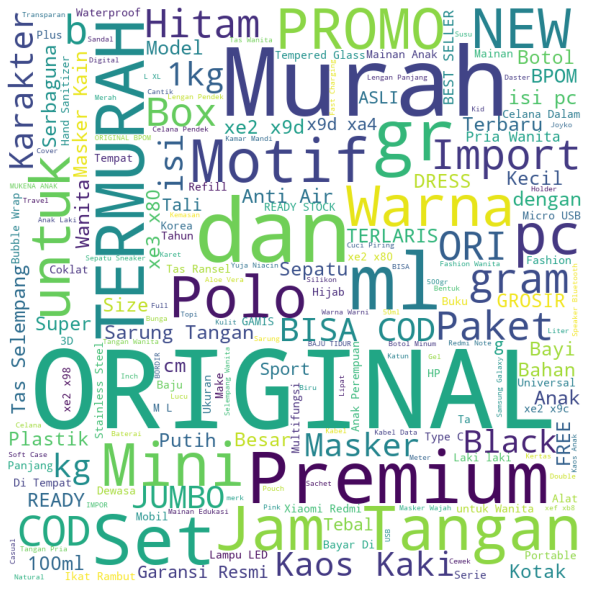

  0%|          | 0/34250 [00:00<?, ?it/s]

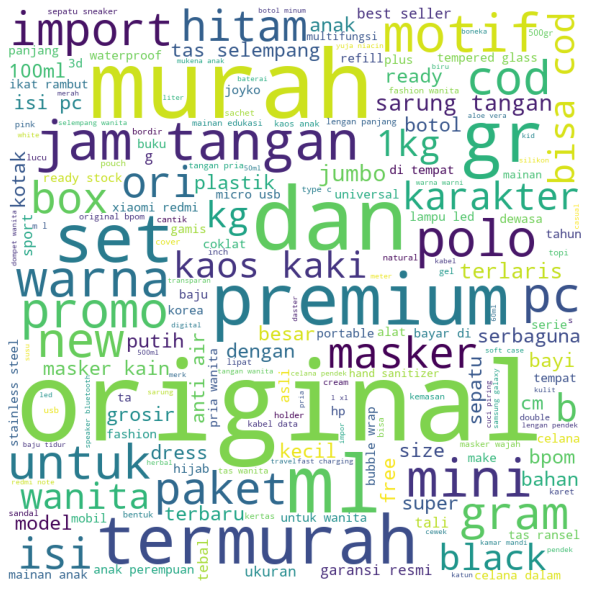

In [14]:
stopwords_wc = set(STOPWORDS) 
token_text = ''

for i in tqdm(title_text):
    token_l = i.split()
    token_text += " ".join(token_l) + " " 
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_wc, 
                min_font_size = 10).generate(token_text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

data['title'] = data['title'].map(preprocess_title)

stopwords_wc = set(STOPWORDS) 
token_text = ''
title_text = data['title'].values
for i in tqdm(title_text):
    token_l = i.split()
    token_text += " ".join(token_l) + " " 
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_wc, 
                min_font_size = 10).generate(token_text)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [15]:
data['title'] 

0                                paper bag victoria secret
1        double tape 3m vhb 12 mm x 4 5 original double...
2              maling tts canned pork luncheon meat 397 gr
3        daster batik lengan pendek motif acak campur l...
4                          nescafe xc3x89clair latte 220ml
                               ...                        
34245    masker bahan kain spunbond non woven 75 gsm 3 ...
34246          mamypoko pants royal soft s 70 popok celana
34247    khanzaacc robot re101s 1 2mm subwoofer bass me...
34248    kaldu non msg halal mama kamu ayam kampung sap...
34249     flex tape pelapis bocor isolasi ajaib anti bocor
Name: title, Length: 34250, dtype: object

# Extract & Store OCR from image 

In [43]:
# Use this for OCR extraction
OCR = []
for i in tqdm.tqdm(range(data.shape[0])):
    img = cv2.imread(data['path'].iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(img)
    text = " ".join(text.split())
    if len(text) != 0:
        OCR.append(text)
    else:
        OCR.append('Nothing Found')

data['OCR'] = OCR

data['processed_OCR'] = data['OCR'].map(preprocess_title)

## Merge OCR text with Product title

In [ ]:
data["title"] = df["title"] + df["processed_OCR"]

In [ ]:
data.to_csv('processed_title_and_ocr_sw.csv')

## View image phash

In [16]:
train['image_phash'][0]

'94974f937d4c2433'

In [17]:
imagehash.hex_to_hash(train['image_phash'][0])

array([[ True, False, False,  True, False,  True, False, False],
       [ True, False, False,  True, False,  True,  True,  True],
       [False,  True, False, False,  True,  True,  True,  True],
       [ True, False, False,  True, False, False,  True,  True],
       [False,  True,  True,  True,  True,  True, False,  True],
       [False,  True, False, False,  True,  True, False, False],
       [False, False,  True, False, False,  True, False, False],
       [False, False,  True,  True, False, False,  True,  True]])

**Inference:**
8x8 image - 8x8 fragments(Hash) representing the actual image

# Baseline Model: Find similar images using Hash algorithm

In [24]:
def matchByImagePhash(phash_array):
    """
    Every image is compared with every other image. 
    close to '0' matrix value is more similar
    
    Output - phash diff matrix (using pandas data frame)
    """
    phashs = phash_array.apply(lambda x: imagehash.hex_to_hash(x))
    phash_matrix = pd.DataFrame()

    for idx, i in enumerate(phash_array):
        phash_matrix = pd.concat([phash_matrix, phashs - imagehash.hex_to_hash(i)], 
                                 axis = 1)
    phash_matrix.columns = range(len(phash_array))
    return phash_matrix

In [25]:
train_sample = train.iloc[:1000, :]
matches = matchByImagePhash(train_sample['image_phash'])
matches

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,42,40,30,32,34,32,30,38,36,...,26,28,34,32,26,28,42,34,26,26
1,42,0,28,28,34,32,36,24,28,32,...,32,28,30,28,42,32,30,32,32,34
2,40,28,0,34,44,26,34,32,28,32,...,34,42,30,30,32,36,24,32,30,24
3,30,28,34,0,34,40,30,32,34,30,...,28,34,38,32,38,28,38,28,30,30
4,32,34,44,34,0,32,30,30,36,30,...,36,22,28,32,26,24,36,34,32,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28,32,36,28,24,32,34,30,36,38,...,34,28,26,26,32,0,34,32,30,32
996,42,30,24,38,36,24,32,30,34,36,...,24,36,28,36,40,34,0,26,34,26
997,34,32,32,28,34,32,30,28,38,30,...,34,32,38,34,30,32,26,0,34,32
998,26,32,30,30,32,36,40,36,30,30,...,34,36,36,32,26,30,34,34,0,28


In [26]:
test_match = matchByImagePhash(test['image_phash'][:3])
test_match

,0,1,2
0,0,36,26
1,36,0,32
2,26,32,0


## Find matches by hash similarity score

In [27]:
match = []
for i in range(len(matches)):
    match.append(matches.iloc[i, :][(matches.iloc[i, :] == 0)].index.values)
match = pd.Series(match)

match[match.apply(lambda x: len(x) > 1)]

11            [11, 12]
12            [11, 12]
28            [28, 29]
29            [28, 29]
56            [56, 57]
            ...       
891    [889, 890, 891]
903         [903, 904]
904         [903, 904]
990         [132, 990]
997         [520, 997]
Length: 90, dtype: object

#  View Similar images

In [29]:
def visualize(image_path):
    """
    Function for visualization of images
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    plt.imshow(img)
    plt.axis('off')

## Exact match 

### Example-1

In [33]:
train_sample.loc[[11,12],['posting_id','image_phash','title','label_group']]

,posting_id,image_phash,title,label_group
11,train_2496690777,eab5c295966ac368,pashmina kusut rawis polos crinkle shawl murah...,509010932
12,train_2771755203,eab5c295966ac368,pashmina kusut rawis polos crinkle shawl murah...,509010932


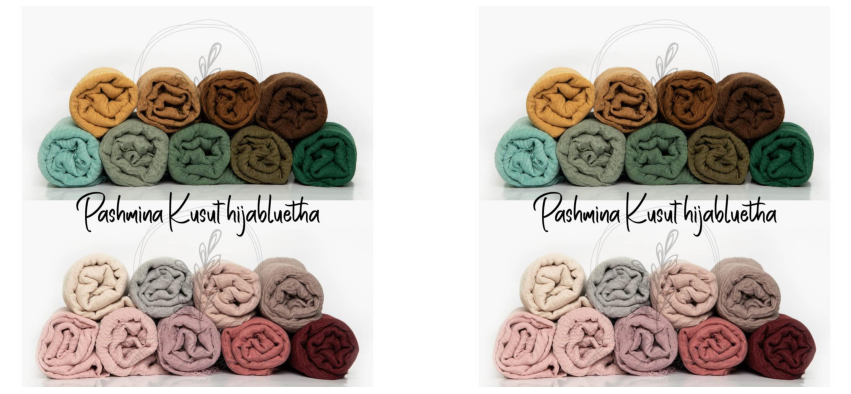

In [32]:
plt.figure(figsize = (15, 10))
for idx, i in enumerate([train_sample.loc[11, 'path'], 
                         train_sample.loc[12, 'path']]):
    plt.subplot(1, 2, idx + 1)
    visualize(i)
plt.show()

### Example-2

In [34]:
train_sample.loc[[56,57],['posting_id','image_phash','title','label_group']]

,posting_id,image_phash,title,label_group
56,train_2281183509,e29b9d52d8a649ac,dzuvia tunik neda tunik,1356633425
57,train_615566263,e29b9d52d8a649ac,tunik dzuvia kancing hidup syari moscrepe premium,1356633425


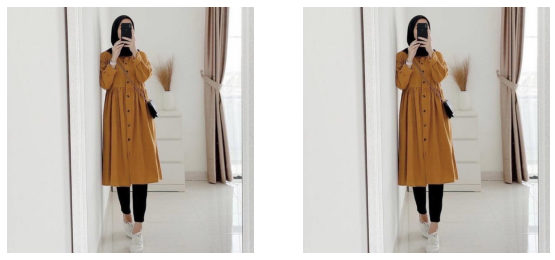

In [35]:
plt.figure(figsize = (15, 10))
for idx, i in enumerate([
                         train_sample.loc[56, 'path'], 
                         train_sample.loc[57, 'path']
                        ]):
    plt.subplot(1, 3, idx + 1)
    visualize(i)
plt.show()

### Example-3

In [36]:
train_sample.loc[[98,99],['posting_id','image_phash','title','label_group']]

,posting_id,image_phash,title,label_group
98,train_2856183961,ee9690c347ceb02e,sabun pemutih tzuki original penghilang jerawa...,3489985175
99,train_1420726013,ee9690c347ceb02e,tzuki beauty soap,3489985175


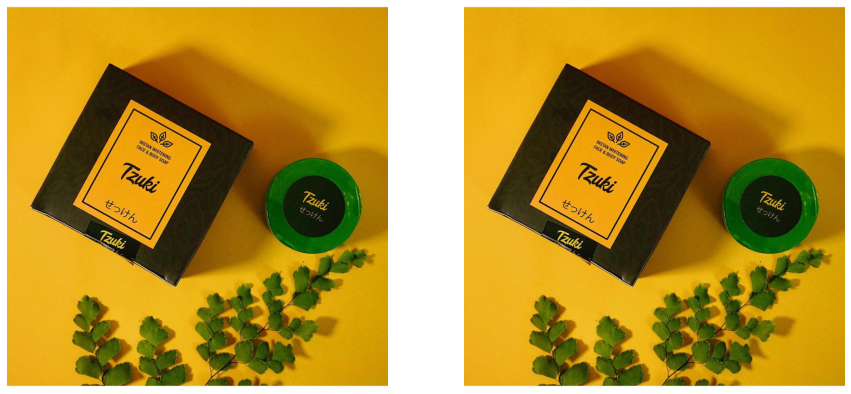

In [37]:
plt.figure(figsize = (15, 10))
for idx, i in enumerate([train_sample.loc[98, 'path'], 
                         train_sample.loc[99, 'path']]):
    plt.subplot(1, 2, idx + 1)
    visualize(i)
plt.show()

## Most-similar images

### Example-1

In [38]:
match = []
for i in range(len(matches)):
    match.append(matches.iloc[i, :][(matches.iloc[i, :] > 0) & 
                                    (matches.iloc[i, :] <= 5)].index.values)
match = pd.Series(match)

match[match.apply(lambda x: len(x) >= 1)]

55     [312]
128    [515]
194    [469]
216    [567]
312     [55]
469    [194]
501    [789]
515    [128]
567    [216]
789    [501]
dtype: object

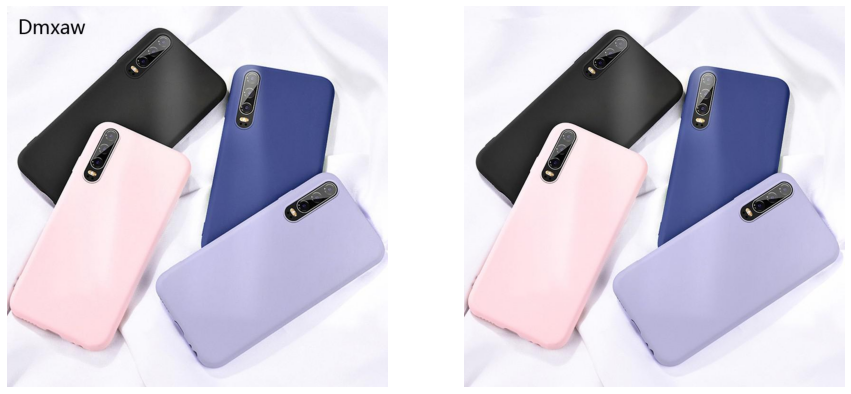

In [39]:
plt.figure(figsize = (15, 10))
for idx, i in enumerate([train_sample.loc[567, 'path'], 
                         train_sample.loc[216, 'path']]):
    plt.subplot(1, 2, idx + 1)
    visualize(i)
plt.show()

### Example-2

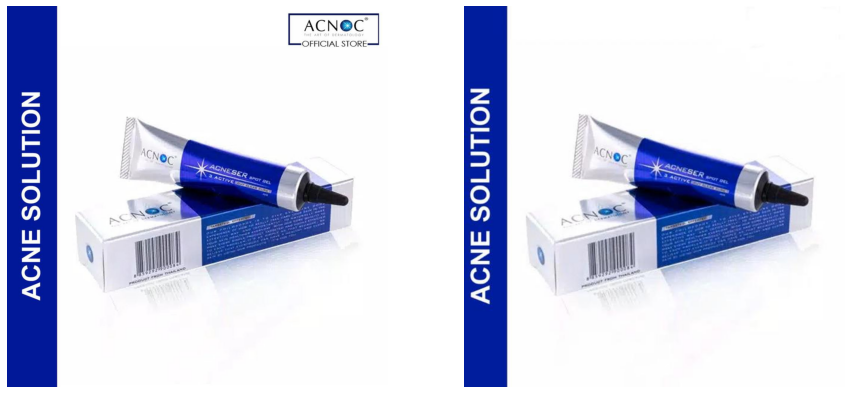

In [40]:
plt.figure(figsize = (15, 10))
for idx, i in enumerate([train_sample.loc[128, 'path'], 
                         train_sample.loc[515, 'path']]):
    plt.subplot(1, 2, idx + 1)
    visualize(i)
plt.show()

# Inferences:

There are multiple ways to find similar products, 
1) Using title & Finding similar product titles.

2) Using product images & Finding similar product images.

3) Using image hash & Finding similar product images.

4) Using image OCR Text matching & Finding similar product images.

#### Step-2: Will be trying baseline models to find similar images, similar titles.